<a href="https://colab.research.google.com/github/vineetisb/GENAI/blob/main/titanic_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (12,8)})

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/datasets/titanic_train_unclean.csv')
df_test = pd.read_csv('/content/drive/MyDrive/datasets/titanic_test_unclean.csv')
df = pd.concat([df_train, df_test], axis=0, sort = True)
df.head(100)



,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,S,8.0500,"Shorney, Mr. Charles Joseph",0,96,3,male,0,0.0,374910
96,71.0,A5,C,34.6542,"Goldschmidt, Mr. George B",0,97,1,male,0,0.0,PC 17754
97,23.0,D10 D12,C,63.3583,"Greenfield, Mr. William Bertram",1,98,1,male,0,1.0,PC 17759
98,34.0,NaN,S,23.0000,"Doling, Mrs. John T (Ada Julia Bone)",1,99,2,female,0,1.0,231919


In [ ]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)


display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1046.0,NaN,NaN,NaN,29.881138,14.413493,0.17,21.0,28.0,39.0,80.0
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1307,3,S,914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,1308.0,NaN,NaN,NaN,33.295479,51.758668,0.0,7.8958,14.4542,31.275,512.3292
Name,1309,1307,"Connolly, Miss. Kate",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309.0,NaN,NaN,NaN,0.385027,0.86556,0.0,0.0,0.0,0.0,9.0
PassengerId,1309.0,NaN,NaN,NaN,655.0,378.020061,1.0,328.0,655.0,982.0,1309.0
Pclass,1309.0,NaN,NaN,NaN,2.294882,0.837836,1.0,2.0,3.0,3.0,3.0
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SibSp,1309.0,NaN,NaN,NaN,0.498854,1.041658,0.0,0.0,0.0,1.0,8.0


In [ ]:
df['Cabin'].isna().sum()

1014

 Impute missing age values
A simple option for the missing age values is to use the median age value. Let's go a little further and use each passenger's Title to estimate their age. E.g. if a passenger has the title of Dr, I will give them the median age value for all other passengers with the same title.

In [ ]:
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=True)
print(df.head())
print("sum ", df['Title'].isna().sum())
df['Title'].value_counts()

there are quite a few different titles. However, many of these titles are just French versions of the more common English titles, e.g. Mme = Madame = Mrs.

We will use the six most common titles, replacing all other titles with the most appropriate of these six.

In [ ]:
# replace rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
           'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
           'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
df.replace({'Title': mapping}, inplace=True)

# confirm that we are left with just six values
df['Title'].value_counts()

Title
Mr        767
Miss      264
Mrs       201
Master     61
Rev         8
Dr          8
Name: count, dtype: int64

In [ ]:
# impute missing Age values using median of Title groups
title_ages = dict(df.groupby('Title')['Age'].median())

# create a column of the average ages
df['age_med'] = df['Title'].apply(lambda x: title_ages[x])

# replace all missing ages with the value in this column
df['Age'].fillna(df['age_med'], inplace=True, )
del df['age_med']

df['Age'].isna().sum()

0

<ipython-input-35-3a597d5afb32>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Title', y='Age', data=df, estimator=np.median, errorbar=None, palette='Blues_d')


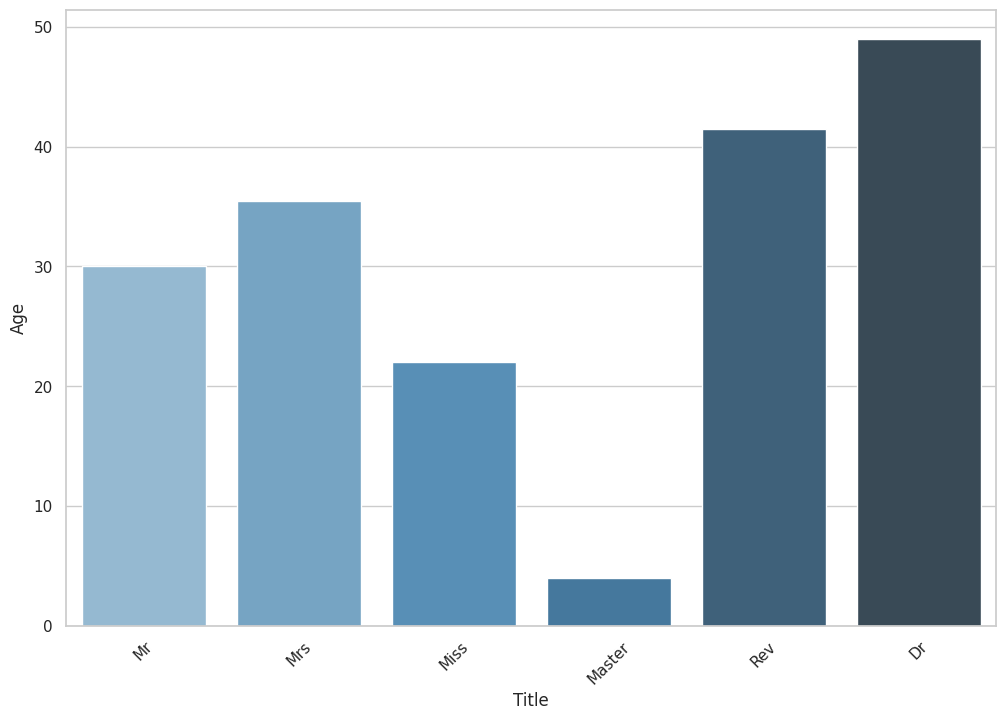

In [ ]:
sns.barplot(x='Title', y='Age', data=df, estimator=np.median, errorbar=None, palette='Blues_d')
plt.xticks(rotation=45)
plt.show()

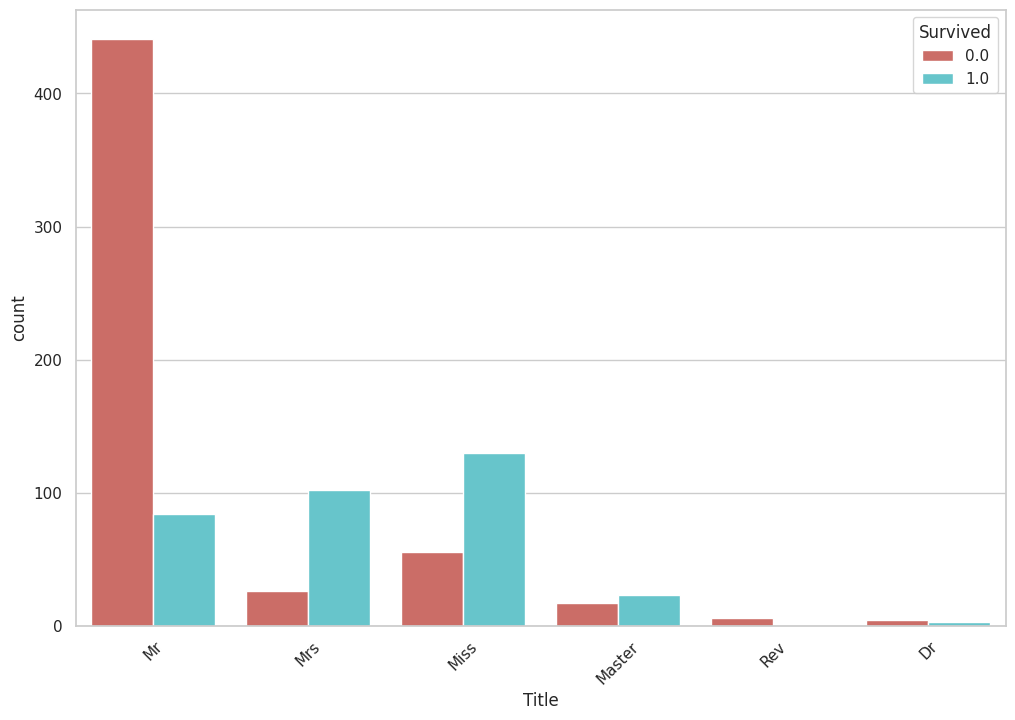

In [ ]:
sns.countplot(x='Title', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# prompt: replace missing values in Fare with median Fare of that class

# impute missing Fare values using median of Pclass groups
class_fares = dict(df.groupby('Pclass')['Fare'].median())

# create a column of the average fares
df['fare_med'] = df['Pclass'].apply(lambda x: class_fares[x])

# replace all missing fares with the value in this column
df['Fare'].fillna(df['fare_med'], inplace=True, )
del df['fare_med']

df['Fare'].isna().sum()


0

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 32.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 46.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 13.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


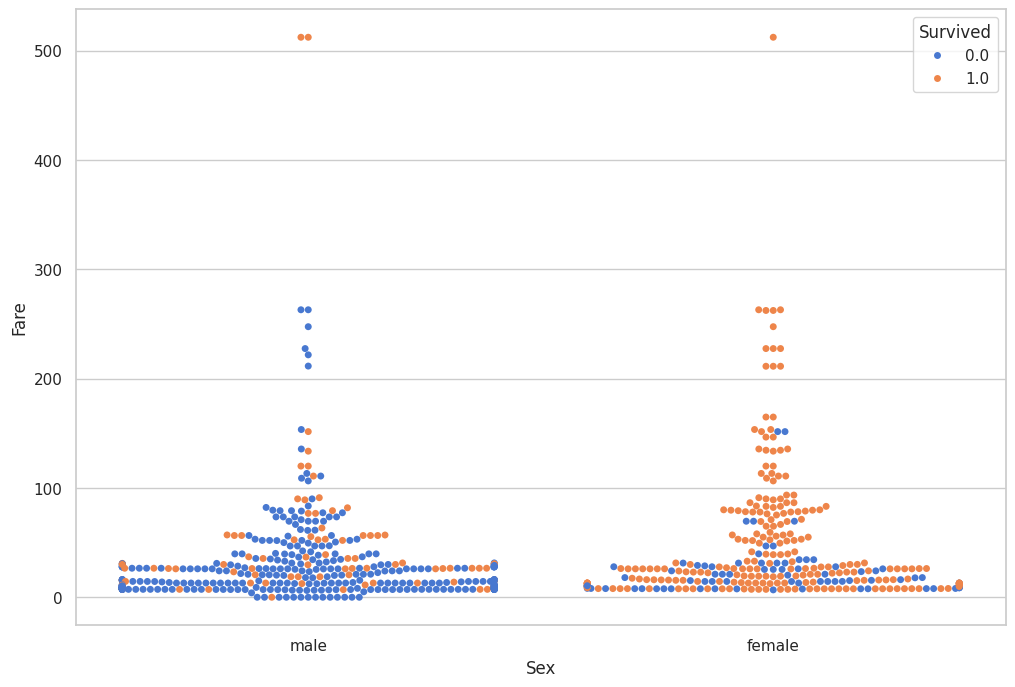

In [ ]:
sns.swarmplot(x='Sex', y='Fare', hue='Survived', data=df)
plt.show()

In [ ]:
df['Embarked'].fillna(method='backfill', inplace=True)
df['Family_Size'] = df['Parch'] + df['SibSp']

# Save Cleaned version
train = df[pd.notnull(df['Survived'])]
test = df[pd.isnull(df['Survived'])]

train.to_csv('/content/drive/MyDrive/datasets/train_clean1.csv', index=False)
test.to_csv('/content/drive/MyDrive/datasets/test_clean1.csv', index=False)